# Fake News Detection by Stance Prediction

The task is to detect fake news by **predicting the stance** associated to every news article in the __[FNC Dataset](https://github.com/FakeNewsChallenge/fnc-1)__.


## Data Input & Preprocessing

Read csv files into Pandas DataFrames and merge them on `Body ID`


In [1]:
import pandas as pd

merged = [None] * 2
for idx, prefix in enumerate(['train', 'test']):
    body_df = pd.read_csv(f'{prefix}_bodies.csv', index_col=0)
    stance_df = pd.read_csv(f'{prefix}_stances.csv')

    merged_df = pd.merge(stance_df, body_df, on='Body ID')
    merged_df = merged_df.rename(
        columns={'Headline': 'headline', 'Body ID': 'body_id',
                     'Stance': 'stance', 'articleBody': 'body'}
    )
    merged[idx] = merged_df

train_df, test_df = merged

In [2]:
import random

len_train = len(train_df)
sample_indices = random.sample(range(len_train), k=int(0.2*len_train))

val_df = train_df.iloc[sample_indices]
train_df = train_df.drop(sample_indices)

### Data Exploration

The training dataset consists of 39978 headline and article pairs.
The validation dataset consists of 9994 headline and article pairs.
The test dataset consists of 25413 headline and article pairs.


                                                headline  body_id     stance
10262  Kim Jong-un relying on ‘cobra wine’ after prob...     1786  unrelated
207       Soldier shot near Canadian parliament building     1034    discuss
42812  Is the Alleged Audio of the Gunshots That Kill...     1817    discuss
11264  Sorry, Everyone: Durex Is Unfortunately Not Ma...     2269      agree
12593  'American bombing had signed my death certific...     1580      agree
34260  Unconfirmed reports saying ISIS UK Hostage Dav...     1224    discuss
8152   'They ate through the ceilings and pooped on t...     2064    discuss
8353   N Korean leader misses annual ritual; sister ‘...     2046  unrelated
20267  Newly Discovered Mass Grave Linked to Missing ...     1213  unrelated
26300  Priest' claim of seeing

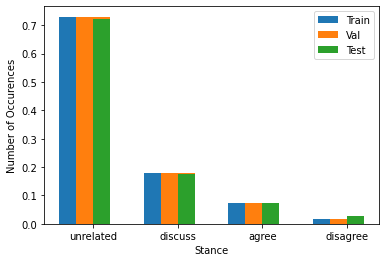

In [3]:
import matplotlib.pyplot as plt

dfs = [train_df, val_df, test_df]
labels = ['training', 'validation', 'test']
df_zip = zip(dfs, labels)
for df, label in df_zip:
    print(f'The {label} dataset consists of {len(df)} headline and article pairs.')

print('\n')

# dropping body text to not clog up output. N.B. drop is not inplace by default
print(train_df.drop(columns=['body']).sample(10))   
print('\n')

train_counts = train_df['stance'].value_counts(normalize=True)
test_counts = test_df['stance'].value_counts(normalize=True)

val_counts = val_df['stance'].value_counts(normalize=True)

plt.figure()
plt.bar(train_counts.index,train_counts.values, width=-0.4, align='edge', label='Train')
plt.bar(val_counts.index,train_counts.values, width=0.4, align='center', label='Val')
plt.bar(test_counts.index,test_counts.values, width=0.2, align='edge', label='Test')
plt.legend()
plt.xlabel('Stance')
plt.ylabel('Number of Occurences')

plt.show()


## Feature Extraction

### TF/IDF

Uses the `scikit-learn` module's implementation of TF/IDF. Built on both the headlines and bodies in the train dataset, and fit to both the train and test dataset.


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(decode_error='ignore', lowercase=True, min_df=2)

raw = {label: np.concatenate((df['body'].drop_duplicates().values,
                              df['headline'].drop_duplicates().values))
                              for df, label in zip(dfs, labels)}



tf_idf = {key: vectorizer.fit_transform(value.astype('U'))
            for key, value in raw.items()}


for key, value in tf_idf.items():
    print(f'{key} feature size: {value.shape}')

training feature size: (3302, 14129)
validation feature size: (3029, 13213)
test feature size: (1794, 10453)


#### Sampling ten random features from the TF/IDF dictionary

In [5]:
print(random.sample(vectorizer.get_feature_names(), 10))

['everything', 'pdf', 'jimmy', 'jordan', 'gauge', 'prisoners', 'white', 'associated', 'intergovernmental', 'mega']


### BERT Transformer

In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
LEN_MAX_INPUT = tokenizer.max_model_input_sizes['bert-base-uncased']

In [7]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:LEN_MAX_INPUT-2]
    return tokens

In [8]:
from torchtext.legacy import data

TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)

LABEL = data.LabelField(dtype = str)


#### Create a dataset

Get item returns BERT tokenized IDs and their stance

In [20]:
import torch

class DataFrameDataset(data.Dataset):

    def __init__(self, df):
        self.df = df


    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        items = self.df.iloc[idx]
        headline = tokenizer.convert_tokens_to_ids(tokenize_and_cut(items['headline']))
        body = tokenizer.convert_tokens_to_ids(tokenize_and_cut(items['body']))
        return {'headline': headline, 'body': body, 'labels': items['stance']}

datasets = [DataFrameDataset(df) for df in dfs]
dataloaders = [torch.utils.data.DataLoader(d, shuffle=True, batch_size=32, drop_last=True)
                                            for d in datasets]


In [21]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

train_iter, val_iter, test_iter = [iter(cycle(x)) for x in dataloaders]

In [22]:
print(next(train_iter))

AttributeError: 'str' object has no attribute 'values'